In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import subprocess as sp
from tqdm import tqdm_notebook
import uuid, shutil
import dill
%matplotlib inline

In [ ]:
JAR_PATH = "target/matsim-code-examples-0.0.1-SNAPSHOT.jar"

# Prepare runner

In [7]:
try:
    os.mkdir("output")
except FileExistsError:
    pass

In [8]:
def run_unconstrained(
        strategy, innovation_rate = 0.1, sample = 0, 
        car_score = -1.0, pt_score = -2.0, use_epsilons = False, innovation_strategy = "RandomMode",
        iterations = 300, name = None):
    if name is None: name = str(uuid.uuid1())
        
    command = [
        "java", "-cp", JAR_PATH, "org.matsim.codeexamples.scoring.pseudoRandomErrors.RunPseudoRandomExperiment",
        "--config:controler.outputDirectory", "output/%s" % name,
        "--selection-strategy", strategy,
        "--innovation-rate", str(innovation_rate),
        "--innovation-strategy", str(innovation_strategy),
        "--config:controler.lastIteration", str(iterations),
        "--config:global.randomSeed", str(sample * 1000),
        "--car-score", str(car_score),
        "--pt-score", str(pt_score),
        "--use-epsilons", str(use_epsilons),
        "--config:global.numberOfThreads", str(8)
    ]
    
    process = sp.Popen(command, stdout = sp.PIPE)
    
    with tqdm_notebook(total = iterations) as progress:
        while process.poll() is None:
            line = process.stdout.readline()

            if b"### ITERATION" in line and b"ENDS" in line:
                progress.update()
                
    df = pd.read_csv("output/%s/modestats.txt" % name, sep = "\t")
    df = df.rename(columns = { "Iteration": "iteration", "car": "car_share", "pt": "pt_share" })
    df = df[["iteration", "car_share", "pt_share"]]
    
    shutil.rmtree("output/%s" % name)
    
    return df

# Quick test
run_unconstrained("BestScore", 0.1, iterations = 10, use_epsilons = True)
pass

# Unconstrained experiments, Standard MATSim

These experiments run without any frozen epsilons, but with standard MATSim. They are supposed to show how MATSim works in terms of mode choice (i.e. finding the best-response solution), regardless of the selection strategy used.

In [5]:
SAMPLE_SIZE = 10
ITERATIONS = 200

## Strategy comparison and varying innovation rate

In [6]:
INNOVATION_RATES = [0.05, 0.1, 0.2]

In [7]:
df_innovation_rates = []

for strategy in ["BestScore", "ChangeExpBeta"]:
    for innovation_rate in INNOVATION_RATES:
        for sample in range(SAMPLE_SIZE):
            df_sample = run_unconstrained(
                strategy = strategy, innovation_rate = innovation_rate, sample = sample,
                iterations = ITERATIONS
            )
            
            df_sample["sample"] = sample
            df_sample["innovation_rate"] = innovation_rate
            df_sample["strategy"] = strategy
            
            df_innovation_rates.append(df_sample)

df_innovation_rates = pd.concat(df_innovation_rates)

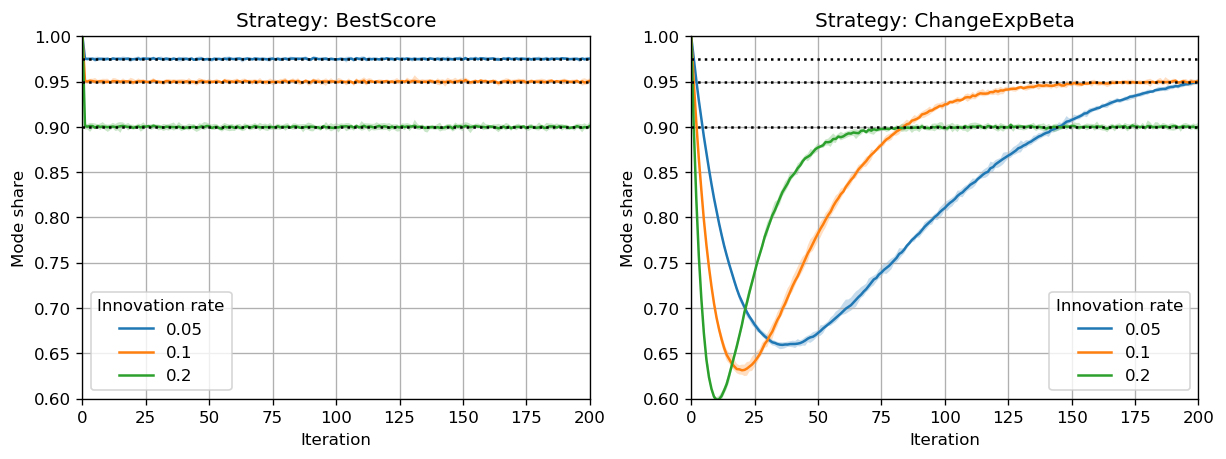

In [8]:
plt.figure(figsize = (12, 4), dpi = 120)

for index, strategy in enumerate(["BestScore", "ChangeExpBeta"]):
    plt.subplot(1, 2, index + 1)
    
    df_strategy = df_innovation_rates[df_innovation_rates["strategy"] == strategy]
    
    for innovation_rate in INNOVATION_RATES:
        df_rate = df_strategy[df_strategy["innovation_rate"] == innovation_rate]
        df_rate = df_rate.groupby("iteration")["car_share"].aggregate(["min", "max", "mean"]).reset_index()
        
        plt.plot(df_rate["iteration"], df_rate["mean"], label = str(innovation_rate))
        plt.fill_between(df_rate["iteration"], df_rate["min"], df_rate["max"], linewidth = 0.0, alpha = 0.25)
    
    plt.plot([0, ITERATIONS], [0.95 + 0.05 * 0.5, 0.95 + 0.05 * 0.5], 'k:')
    plt.plot([0, ITERATIONS], [0.9 + 0.1 * 0.5, 0.9 + 0.1 * 0.5], 'k:')
    plt.plot([0, ITERATIONS], [0.8 + 0.2 * 0.5, 0.8 + 0.2 * 0.5], 'k:')

    plt.legend(loc = "best", title = "Innovation rate")
    plt.grid()
    
    plt.xlabel("Iteration")
    plt.ylabel("Mode share")
    
    plt.ylim([0.6, 1])
    plt.xlim([0, ITERATIONS])
    
    plt.title("Strategy: %s" % strategy)

## Variation of scores

In [9]:
PT_SCORES = [0.0, -0.5, -1.0, -1.5, -2.0]

In [10]:
df_pt_scores = []

for strategy in ["BestScore", "ChangeExpBeta"]:
    for pt_score in PT_SCORES:
        for sample in range(SAMPLE_SIZE):
            df_sample = run_unconstrained(
                strategy = strategy, pt_score = pt_score, sample = sample, iterations = ITERATIONS
            )
            
            df_sample["sample"] = sample
            df_sample["pt_score"] = pt_score
            df_sample["strategy"] = strategy
            
            df_pt_scores.append(df_sample)

df_pt_scores = pd.concat(df_pt_scores)

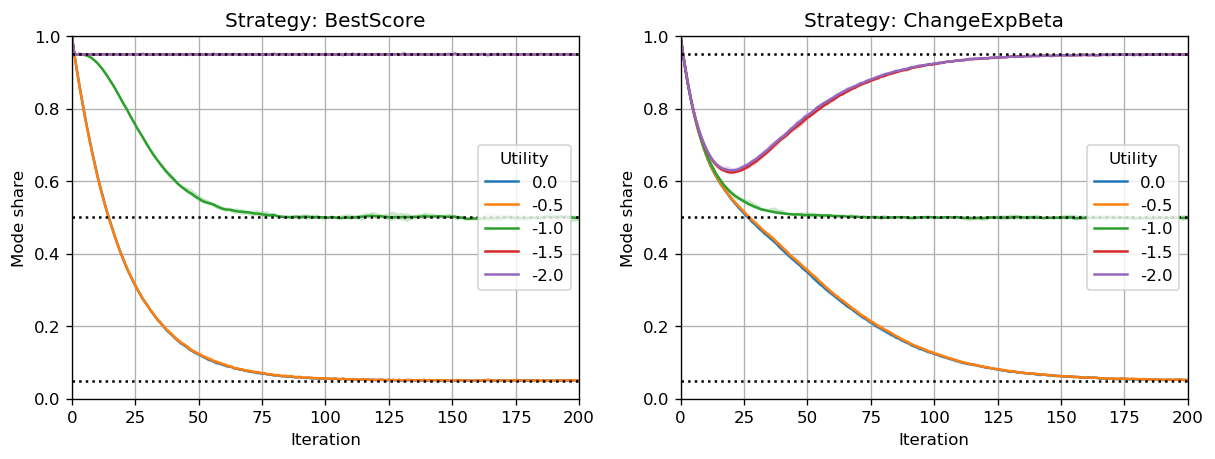

In [11]:
plt.figure(figsize = (12, 4), dpi = 120)

for index, strategy in enumerate(["BestScore", "ChangeExpBeta"]):
    plt.subplot(1, 2, index + 1)
    
    df_strategy = df_pt_scores[df_pt_scores["strategy"] == strategy]

    for pt_score in PT_SCORES:
        df_score = df_strategy[df_strategy["pt_score"] == pt_score]
        df_score = df_score.groupby("iteration")["car_share"].aggregate(["min", "max", "mean"]).reset_index()
        
        plt.plot(df_score["iteration"], df_score["mean"], label = str(pt_score))
        plt.fill_between(df_score["iteration"], df_score["min"], df_score["max"], linewidth = 0.0, alpha = 0.25)   
        
    plt.plot([0, ITERATIONS], [0.9 + 0.1 * 0.5, 0.9 + 0.1 * 0.5], 'k:')
    plt.plot([0, ITERATIONS], [0.5, 0.5], 'k:')
    plt.plot([0, ITERATIONS], [0.1 * 0.5, 0.1 * 0.5], 'k:')
        
    plt.legend(loc = "center right", title = "Utility")
    plt.grid()
    
    plt.xlabel("Iteration")
    plt.ylabel("Mode share")
    
    plt.ylim([0, 1])
    plt.xlim([0, ITERATIONS])
    
    plt.title("Strategy: %s" % strategy)

## Adding epsilons

In [12]:
PT_SCORES = [-1.0, -1.25, -1.5, -2.0, -2.5, -3.0]

In [13]:
df_with_epsilons = []

for strategy in ["BestScore", "ChangeExpBeta"]:
    for pt_score in PT_SCORES:
        for sample in range(SAMPLE_SIZE):
            df_sample = run_unconstrained(
                strategy = strategy, pt_score = pt_score, sample = sample, iterations = ITERATIONS,
                use_epsilons = True, # Here we use epsilons!
                innovation_rate = 0.1
            )
            
            df_sample["sample"] = sample
            df_sample["pt_score"] = pt_score
            df_sample["strategy"] = strategy
            
            df_with_epsilons.append(df_sample)

df_with_epsilons = pd.concat(df_with_epsilons)

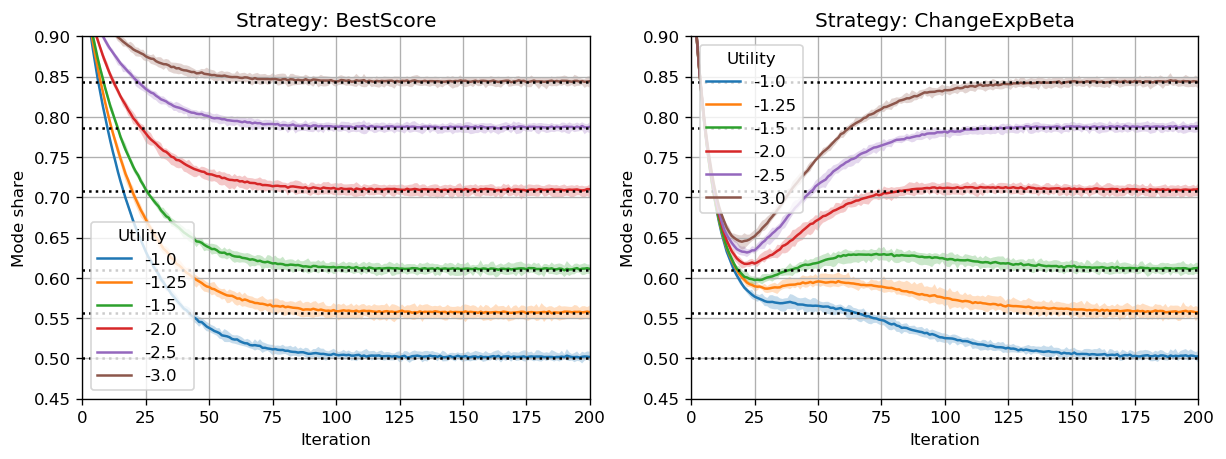

In [14]:
plt.figure(figsize = (12, 4), dpi = 120)

for index, strategy in enumerate(["BestScore", "ChangeExpBeta"]):
    plt.subplot(1, 2, index + 1)
    
    df_strategy = df_with_epsilons[df_with_epsilons["strategy"] == strategy]

    for pt_score in PT_SCORES:        
        df_score = df_strategy[df_strategy["pt_score"] == pt_score]
        df_score = df_score.groupby("iteration")["car_share"].aggregate(["min", "max", "mean"]).reset_index()
        
        plt.plot(df_score["iteration"], df_score["mean"], label = str(pt_score))
        plt.fill_between(df_score["iteration"], df_score["min"], df_score["max"], linewidth = 0.0, alpha = 0.25)
        
        base_value = np.exp(-1.0) / (np.exp(-1.0) + np.exp(pt_score))
        resulting_value = base_value * 0.9 + 0.5 * 0.1
        plt.plot([0, ITERATIONS], [resulting_value, resulting_value], 'k:')
        
    plt.legend(loc = "best", title = "Utility")
    plt.grid()
    
    plt.xlabel("Iteration")
    plt.ylabel("Mode share")
    
    plt.ylim([0.45, 0.9])
    plt.xlim([0, ITERATIONS])
    
    plt.title("Strategy: %s" % strategy)

## Dependency on replanning rate

In [15]:
INNOVATION_RATES = [0.05, 0.1, 0.2, 0.5]

In [16]:
df_epsilon_innovation_rate = []

for strategy in ["BestScore", "ChangeExpBeta"]:
    for innovation_rate in INNOVATION_RATES:
        for sample in range(SAMPLE_SIZE):
            df_sample = run_unconstrained(
                strategy = strategy, pt_score = -2.0, sample = sample, iterations = ITERATIONS,
                use_epsilons = True, # Here we use epsilons!
                innovation_rate = innovation_rate
            )
            
            df_sample["sample"] = sample
            df_sample["innovation_rate"] = innovation_rate
            df_sample["strategy"] = strategy
            
            df_epsilon_innovation_rate.append(df_sample)

df_epsilon_innovation_rate = pd.concat(df_epsilon_innovation_rate)

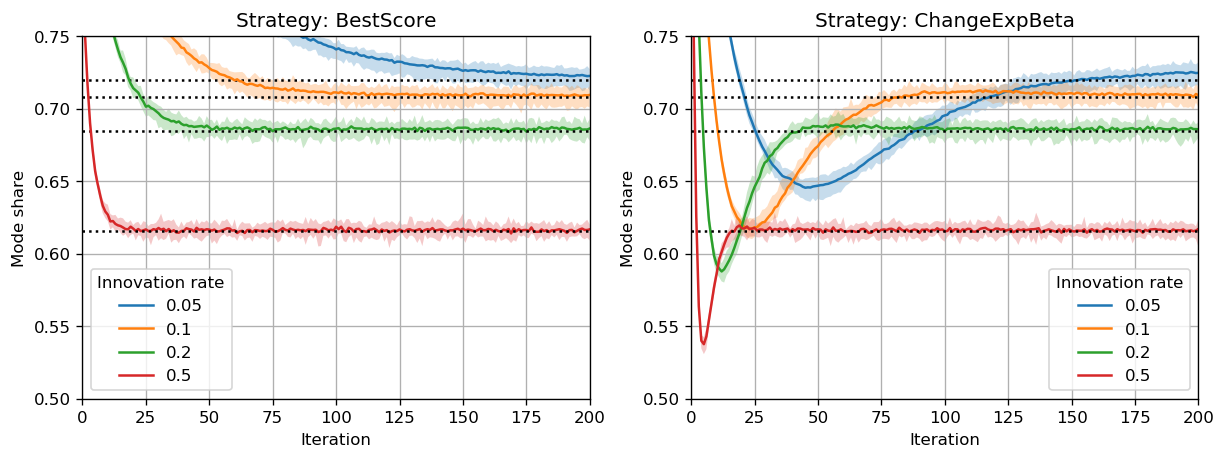

In [17]:
plt.figure(figsize = (12, 4), dpi = 120)

for index, strategy in enumerate(["BestScore", "ChangeExpBeta"]):
    plt.subplot(1, 2, index + 1)
    
    df_strategy = df_epsilon_innovation_rate[df_epsilon_innovation_rate["strategy"] == strategy]

    for innovation_rate in INNOVATION_RATES:
        df_score = df_strategy[df_strategy["innovation_rate"] == innovation_rate]
        df_score = df_score.groupby("iteration")["car_share"].aggregate(["min", "max", "mean"]).reset_index()
        
        plt.plot(df_score["iteration"], df_score["mean"], label = str(innovation_rate))
        plt.fill_between(df_score["iteration"], df_score["min"], df_score["max"], linewidth = 0.0, alpha = 0.25)
        
        base_value = np.exp(-1.0) / (np.exp(-1.0) + np.exp(-2.0))
        resulting_value = base_value * (1.0 - innovation_rate) + 0.5 * innovation_rate
        plt.plot([0, ITERATIONS], [resulting_value, resulting_value], 'k:')
        
    plt.legend(loc = "best", title = "Innovation rate")
    plt.grid()
    
    plt.xlabel("Iteration")
    plt.ylabel("Mode share")
    
    plt.ylim([0.5, 0.75])
    plt.xlim([0, ITERATIONS])
    
    plt.title("Strategy: %s" % strategy)